# Lab4: GPU Programming Lab

### Name: Write your names (Group)

#1) Hafiz Muhammad Abubaker siddique
##siddiquemuhammadabubaker915@gmail.com
##hafsid21@students.hh.se
##199312257794

#2) Rana Abdul Basit Javaid
##abdulbasitjavaid@gmail.com
##199102230431


This lab is an introduction of GPU programming with cuda using python. The consists of 3 exercises and a homework. 

- <font color='red'><b> After each exercise, write a detailed summary explaining what you have done, your observations and  conclusions. </b></font>
- <font color='red'><b> Make sure to write your name and your partner name (as registred in Halmstad University) in the name section above. </b></font>
    
- <font color='red'><b> You can do the lab in a group of a maximum of two students. </b></font>

- <font color='red'><b> Only one of the students upload the lab to the blackboard. </b></font>

# CUDA
CUDA is a parallel programming platform and an API that facilitates the access to the CUDA-Enabled GPU functuonality for general purpose computing. It allows speeding up the software by utilizing the GPU power for the parallelizable part of the computation. Many Deep Learning platforms like tenserflow, keras, pytorch and others, rely on CUDA for their computations.

## Common CUDA terminology:
- <b>Host:</b> The CPU
- <b>Device:</b> The GPU
- <b>Host Memory:</b> The system main memory
- <b>Device Memory:</b> The GPU onboard memory
- <b>kernel:</b> A function that runs on the Device

Threads are organized into a grid of blocks, where each block contains a subset of the threads that can cooperate using a block shared memory and can synchronize within each block.

<img src='https://drive.google.com/uc?id=1QzXBVWki0M80KKY_CPzQu1ivE3fAcf2U' width="50%" height="50%"></img>


Parallel portions of an application are executed on the device (GPU) as kernels, where an array of threads excutes each kernel. Each thread has an ID, by which it controls the portion of the data to excute the Kernel. All threads runs the same code on different portions of the data. Grids and Blocls can be organized as 1D, 2D, or 3D arrays. 

<img src='https://drive.google.com/uc?id=1vqh749XFQhfZwq7m7E-VXscBblh58mei' width="50%" height="50%"></img>


# Numba
CUDA is designed to work with C++, but in this Lab we will work with Numba; a Python JIT compiler that translates subsets of the code into machine code, and enables writing a parallel GPU algorithms in Python

## Numba installation


conda install numba

pip install numba

# Kernel 
- A Kernel is declared as a function with @cuda.jit decorator.
- A Kernel function cannot have a return value and manages outputs as input-output arrays

In [ ]:
import numpy as np
import math
import numba as nb
from numba import cuda
import time
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
# kernel decleration
@cuda.jit
def my_kernel(io_array):
    threadId = cuda.grid(1)
    io_array[threadId] += 10
    pass


To invoc a kernal you have to specify number of blocks in the grid, and the number of threads per block. This can be done by specifying the number of threads per block and calculating how many blocks are required in the grid based on the size of the data.

<font color=red>Important note: In the case that the data size is not divisable by the the number of thread per block, we take the ceiling of the number to reserve an extra block for the remaining part of the data. So the threads in the last block will not be fully occupied.</font>

In [ ]:
# kernel invocation
data = np.ones(256)

threadsperblock = 32
blockspergrid = math.ceil(len(data)/threadsperblock)

my_kernel[blockspergrid, threadsperblock](data)


# Exercise 1: Element-wise operation

The following kernel takes 1D array as input and computes the element-wise cube-root x^(1/3) for each element in the array. This an example of an arbitrary costy operation.

- pos: holds the position in the data on which the thread will work.
- Always check if the position exceeds the length of the data for the sake of cases when the data length is not devisable by the number of threads per block.

<img src='https://drive.google.com/uc?id=1AndzjaLH-Lc7N4cg1Ue_zEB3EyJni89N' width="50%" height="50%"></img>

Read the code below and compute the position of the thread on which it will do the computation in the output array.

In [ ]:
# kernel decleration
@cuda.jit
def my_kernel(io_array):
    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    ty = cuda.blockIdx.x
     # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    
    
    # Compute flattened index inside the array
    #pos = cuda.grid(1) # this function returns the same value for the position in a 1D grid
    
    #TODO: compute the correct pos value based on the tread index and the block index and the block width
    pos = tx + ty * bw

    
    if pos < io_array.size:
        io_array[pos] = io_array[pos]**(1/3)
        

# kernel invocation
data = np.ones(2048)*27
threadsperblock = 256
blockspergrid = math.ceil(data.shape[0] / threadsperblock)
my_kernel[blockspergrid, threadsperblock](data)
print(data)

[3. 3. 3. ... 3. 3. 3.]


In [ ]:
data = np.ones(10000000)
%timeit np.cbrt(data)

1 loop, best of 5: 198 ms per loop


In [ ]:
data = np.ones(10000000)
threadsperblock = 1024
blockspergrid = math.ceil(data.shape[0] / threadsperblock)
%timeit my_kernel[blockspergrid, threadsperblock](data)

10 loops, best of 5: 43.4 ms per loop


### Comparison between the previous kernel and Numpy 
- Try different array sizes and compare between CPU (using numpy) and GPU.
- Plot a graph that shows the array sizes on the x axis and the computation time on the y axis of both your kernel and numpy (on the same plot). 
- Is there a relation between the size of the array and difference in performance? Explain what you notice.

### Exercise 1: Results


## Exercise 2: Matrix Multiplication

In matrix multiplication, every kernel will be reponsible of computing one element of the output matrix. It reads one row from the first matrix (A) and one column form the second matrix (B) and computes the dot product of these two vectors and place it in the corresponding cell in the output matrix (C) as shown in the following figure.

<img src='https://drive.google.com/uc?id=16EMuj46QLdwKmIDPU0P6AepZ9SNssb2s' width="50%" height="50%"></img>

Write a kernel to do the multiplication of two matrices.

1000 loops, best of 5: 197 µs per loop
The slowest run took 4.28 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 600 µs per loop


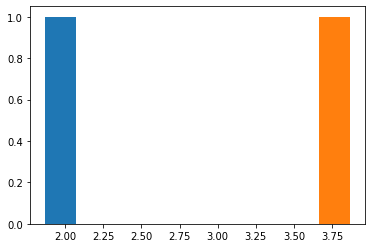

In [ ]:
# Small Size CPU vs GPU

smallData = np.ones(10000)

# CPU
startTime = time.time()
%timeit np.cbrt(smallData)
stopTime = time.time()
totalCPUTime = stopTime - startTime

# GPU
startTime = time.time()
threadsperblock = 1024
blockspergrid = math.ceil(smallData[0] / threadsperblock)
%timeit my_kernel[blockspergrid, threadsperblock](smallData)
stopTime = time.time()
totalGPUTime = stopTime - startTime

# Plot

plt.bar([totalCPUTime], smallData, width=0.05)
plt.bar([totalGPUTime], smallData, width=0.05)
plt.xlabel("Data Size")
plt.ylabel("Time")
plt.show()



In [ ]:
# Large Size CPU vs GPU

largeData = np.ones(10000000)

# CPU
startTime = time.time()
%timeit np.cbrt(largeData)
stopTime = time.time()
totalCPUTime = stopTime - startTime

# GPU
startTime = time.time()
threadsperblock = 1024
blockspergrid = math.ceil(largeData[0] / threadsperblock)
%timeit my_kernel[blockspergrid, threadsperblock](largeData)
stopTime = time.time()
totalGPUTime = stopTime - startTime

# Plot

plt.bar([totalCPUTime], largeData, width=0.05)
plt.bar([totalGPUTime], largeData, width=0.05)
plt.xlabel("Data Size")
plt.ylabel("Time")
plt.show()

1 loop, best of 5: 197 ms per loop
10 loops, best of 5: 35.7 ms per loop


In [ ]:
# CUDA kernel
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp


### Create a host function to invoke the kernel

It is a good practice to manually copy the matrices to Device (the GPU memory) using "cuda.to_device" to reduce the unnecessary data transfer between the device and the host.


To test the kernel "mat_mul" we prepare the host function "gpu_dot" which will take two matrices as parameters and returns the the output matrix. The job of this host function is to perpare the data and to invoke the kernel.

Read the code below and calculate how many blocks are required to start the kernel. Use the calculated values to invoke the kernel.

In [ ]:
def gpu_dot(A, B):
    #Copy the input matrices to the gpu
    start_copy_time = time.time()
    A_global_mem = cuda.to_device(A)
    B_global_mem = cuda.to_device(B)

    # Allocate memory on the device for the result (Note the shape of the output matrix)
    C_global_mem = cuda.device_array((A.shape[0], B.shape[1]), np.float32)
    
    # Configure the blocks
    # Specify how many threads per block
    threadsperblock = (32, 32)
    
    #TODO: Calculate how many blocks are required
    Xblockspergrid =  int(math.ceil(A.shape[0] / threadsperblock[0]))
    Yblockspergrid =  int(math.ceil(B.shape[1] / threadsperblock[1]))
    blockspergrid = (Xblockspergrid, Yblockspergrid)

    dt = time.time()-start_copy_time
    print(f'Copying Input to GPU time: {dt} s')
    start_mult_time = time.time()
    
    #TODO: Start the kernel based on the calculated grid 
    matmul[blockspergrid, threadsperblock](A_global_mem, B_global_mem, C_global_mem)
    
    dt = time.time()-start_mult_time
    print(f'Multiplication Time: {dt} s')
    # Copy the result back to the host
    start_copy_back_time = time.time()
    C = C_global_mem.copy_to_host()
    dt = time.time()-start_copy_back_time
    print(f'Copy result back time: {dt} s')
    dt = time.time()-start_copy_time
    print(f'Total time: {dt} s')
    return C

# Input Test arrays
A = np.full((16384, 2048), 3, np.float32) # matrix containing all 3's
B = np.full((2048, 16384), 4, np.float32) # matrix containing all 4's

#Test the host function
C = gpu_dot(A,B)
print(f'Input Shapes:A:{A.shape}, B:{B.shape}')

print('Output Shape:', C.shape)
print('Output:',C)


Copying Input to GPU time: 0.05836033821105957 s
Multiplication Time: 0.16926980018615723 s
Copy result back time: 0.460146427154541 s
Total time: 0.6881165504455566 s
Input Shapes:A:(16384, 2048), B:(2048, 16384)


### Testing the calculations time compared to numpy

In [ ]:
%timeit np.dot(A,B)

1 loop, best of 5: 12.7 s per loop


### Comparison between the previous gpu_dot and Numpy.dot
- Try different array sizes and compare between CPU (using np.dot) and GPU (using gpu_dot).
- Plot a graph that shows the array sizes (bacause it is a 2D matrix, you can consider the size to be the hight x width) on the x axis and the computation time on the y axis of both your kernel and numpy (on the same plot). 
- Explain what you notice.

### Exercise 2: Results

In [ ]:
# Small Size CPU vs GPU

X = np.full((1000, 100), 3, np.float32)
Y = np.full((100, 1000), 4, np.float32)

# CPU
startTime = time.time()
%timeit np.dot(X, Y)
stopTime = time.time()
totalCPUTime = stopTime - startTime

# GPU
startTime = time.time()
%timeit gpu_dot(X, Y)
stopTime = time.time()
totalGPUTime = stopTime - startTime

# Plot

plt.bar([totalCPUTime], '1000 x 100', width=0.05)
plt.bar([totalGPUTime], '1000 x 100', width=0.05)
plt.xlabel("Data")
plt.ylabel("Time")
plt.show()

In [ ]:
# Large Size CPU vs GPU

X = np.full((100000, 100), 3, np.float32)
Y = np.full((100, 100000), 4, np.float32)

# CPU
startTime = time.time()
%timeit np.dot(X, Y)
stopTime = time.time()
totalCPUTime = stopTime - startTime

# GPU
startTime = time.time()
%timeit gpu_dot(X, Y)
stopTime = time.time()
totalGPUTime = stopTime - startTime

# Plot

plt.bar([totalCPUTime], '1000 x 100', width=0.05)
plt.bar([totalGPUTime], '1000 x 100', width=0.05)
plt.xlabel("Data")
plt.ylabel("Time")
plt.show()

## Exercise 3: Distance Matrix
The distance matrix (D) of a data matrix (A) is the matrix that contains the eucleadian distance between each two row vectors as shown in the following figure.

<img src='https://drive.google.com/uc?id=1UMMRYmtPW9_Tonq20GBjxsDLrNFYSTdc' width="50%" height="50%"></img>

where 
$$D[i,j]=D[j,i]=dist(A[i,:], A[j,:])$$


Use what you have learned in the previous exercises to write a kernel and a host function to compute the distance matrix of a data matrix. 


In [ ]:
import numpy as np
from numba import cuda

USE_64 = True

if USE_64:
    bits = 64
    np_type = np.float64
else:
    bits = 32
    np_type = np.float32

@cuda.jit("void(float{}[:, :], float{}[:, :])".format(bits, bits))
def distance_matrix(mat, out):
    #TODO: write a kernel to compute the distance matrix of the input "mat" and place the result in "out"
    m = mat.shape[0]
    n = mat.shape[1]
    i, j = cuda.grid(2)
    d = 0
    if i < m and j < m:
        for k in range(n):
            tmp = mat[i, k] - mat[j, k]
            d += tmp * tmp
        out[i, j] = d

def gpu_dist_matrix(mat):
    #TODO: write a host function to calculate the grid size and use the calculated values to invoke the "distance_Matrix" kernel
    rows = mat.shape[0]

    block_dim = (16, 16)
    grid_dim = (int(rows/block_dim[0] + 1), int(rows/block_dim[1] + 1))

    stream = cuda.stream()
    mat2 = cuda.to_device(np.asarray(mat, dtype=np_type), stream=stream)
    out2 = cuda.device_array((rows, rows))
    distance_matrix[grid_dim, block_dim](mat2, out2)
    out = out2.copy_to_host(stream=stream)
    return out


A = np.random.randn(1024,1024)
D = gpu_dist_matrix(A)
print(D)

[[   0.         2232.76206222 2049.08279642 ... 1928.84672522
  2012.31993927 2202.44881006]
 [2232.76206222    0.         2044.95132355 ... 1956.39805137
  1937.33295833 2147.55623843]
 [2049.08279642 2044.95132355    0.         ... 2079.8856032
  1917.3095798  2048.77443963]
 ...
 [1928.84672522 1956.39805137 2079.8856032  ...    0.
  1983.91926463 1992.91436212]
 [2012.31993927 1937.33295833 1917.3095798  ... 1983.91926463
     0.         1904.72800995]
 [2202.44881006 2147.55623843 2048.77443963 ... 1992.91436212
  1904.72800995    0.        ]]


# Homework: K-Nearest Neighbors (GPU version)

K-Nearest Neighbors is one of the simplest and most intuitive algorithms in machine learning that relies on the principle that close points behave similarly. It is one of the case-based learning algorithms that can learn non-linear complicated decision boundaries with a single hyperparameter, i.e. K the number of nearest neighbors. The problem of this algorithm is that, to find the k nearest neighbors of a specific point, you have to compute the distances to all the points in the training dataset, which is very costly in terms of computation especially with a large amount of data. A great benefit can be achieved by performing such computation on the GPU.

Your task is to implement the K-Nearest Neighbors algorithm using python, and Numba, and CUDA programming.
Identify the parts of the algorithm that can make use of the GPU and implement them as CUDA kernels.

Use the MNIST dataset as an example and implement a K-Nearest Neighbors classifier to classify the image of the digit into its category.

Try different numbers of K and figure out the number that maximizes the accuracy of the classifier.
Build another K-Nearest Neighbors using the Sciket-learn library and compare the computation time with your GPU-enabled algorithm. 

You can download MNIST from Keras library: ( https://keras.io/api/datasets/mnist/ )

### Homework: Reported Time and Accuracy

In [ ]:
from __future__ import print_function
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn import datasets
from skimage import exposure
import numpy as np
import imutils
import cv2
import sklearn

In [ ]:
pip install --upgrade imutils

In [ ]:
pip install opencv-python


In [ ]:
#if int((sklearn.__version__).split(".")[1]) < 18:
	#from sklearn.cross_validation import train_test_split

In [ ]:
from sklearn.model_selection import train_test_split

# load the MNIST digits dataset
mnist = datasets.load_digits()

In [ ]:
# take the MNIST data and construct the training and testing split, using 75% of the
# data for training and 25% for testing
(trainData, testData, trainLabels, testLabels) = train_test_split(np.array(mnist.data),
	mnist.target, test_size=0.25, random_state=42)

# now, let's take 10% of the training data and use that for validation
(trainData, valData, trainLabels, valLabels) = train_test_split(trainData, trainLabels,
	test_size=0.1, random_state=84)



In [ ]:
# show the sizes of each data split
print("training data points: {}".format(len(trainLabels)))
print("validation data points: {}".format(len(valLabels)))
print("testing data points: {}".format(len(testLabels)))

training data points: 1212
validation data points: 135
testing data points: 450


In [ ]:
# initialize the values of k for our k-Nearest Neighbor classifier along with the
# list of accuracies for each value of k
kVals = range(1, 30, 2)
accuracies = []

In [ ]:
# loop over various values of `k` for the k-Nearest Neighbor classifier
for k in range(1, 30, 2):
	# train the k-Nearest Neighbor classifier with the current value of `k`
	model = KNeighborsClassifier(n_neighbors=k)
	model.fit(trainData, trainLabels)

	# evaluate the model and update the accuracies list
	score = model.score(valData, valLabels)
	print("k=%d, accuracy=%.2f%%" % (k, score * 100))
	accuracies.append(score)

# find the value of k that has the largest accuracy
i = int(np.argmax(accuracies))
print("k=%d achieved highest accuracy of %.2f%% on validation data" % (kVals[i],
	accuracies[i] * 100))

k=1, accuracy=99.26%
k=3, accuracy=99.26%
k=5, accuracy=99.26%
k=7, accuracy=99.26%
k=9, accuracy=99.26%
k=11, accuracy=99.26%
k=13, accuracy=99.26%
k=15, accuracy=99.26%
k=17, accuracy=98.52%
k=19, accuracy=98.52%
k=21, accuracy=97.78%
k=23, accuracy=97.04%
k=25, accuracy=97.78%
k=27, accuracy=97.04%
k=29, accuracy=97.04%
k=1 achieved highest accuracy of 99.26% on validation data


In [ ]:
# re-train our classifier using the best k value and predict the labels of the
# test data
model = KNeighborsClassifier(n_neighbors=kVals[i])
model.fit(trainData, trainLabels)
predictions = model.predict(testData)

# show a final classification report demonstrating the accuracy of the classifier
# for each of the digits
print("EVALUATION ON TESTING DATA")
print(classification_report(testLabels, predictions))

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       0.95      1.00      0.97        37
           2       1.00      1.00      1.00        38
           3       0.98      0.98      0.98        46
           4       0.98      0.98      0.98        55
           5       0.98      1.00      0.99        59
           6       1.00      1.00      1.00        45
           7       1.00      0.98      0.99        41
           8       0.97      0.95      0.96        38
           9       0.96      0.94      0.95        48

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



In [ ]:
# loop over a few random digits
for i in list(map(int, np.random.randint(0, high=len(testLabels), size=(5,)))):
	# grab the image and classify it
	image = testData[i]
	prediction = model.predict(image.reshape(1, -1))[0]

	# convert the image for a 64-dim array to an 8 x 8 image compatible with OpenCV,
	# then resize it to 32 x 32 pixels so we can see it better
	image = image.reshape((8, 8)).astype("uint8")
	image = exposure.rescale_intensity(image, out_range=(0, 255))
	image = imutils.resize(image, width=32, inter=cv2.INTER_CUBIC)

	# show the prediction
	print("I think that digit is: {}".format(prediction))
	#cv2.imshow("Image", image)
	cv2.waitKey(0)

I think that digit is: 4
I think that digit is: 8
I think that digit is: 6
I think that digit is: 3
I think that digit is: 2


In [ ]:
# KNN using GPU

# KNN where k=5

  knnOutput = []
  for i in range(len(trainLabel)):
    distances = []
    points = []
    for j in range(len(trainData)):
      distances.append([gpu_dist_matrix(np.array((trainData[j],trainLabel[i]))), j])
      
    distances.sort()
    distances = distances[0:5]
    for d, j in distances:
        points.append(testData[j])
        knnOutput.append(Counter(points).most_common(1)[0][0])

  result = (knnOutput == testLabel).sum() / len(testLabel) 
  print("Accuracy when K=5")
  print(result)

In [ ]:
# KNN where k=15

  knnOutput = []
  for i in range(len(trainLabel)):
    distances = []
    points = []
    for j in range(len(trainData)):
      distances.append([gpu_dist_matrix(np.array((trainData[j],trainLabel[i]))), j])
      
    distances.sort()
    distances = distances[0:15]
    for d, j in distances:
        points.append(testData[j])
        knnOutput.append(Counter(points).most_common(1)[0][0])

  result = (knnOutput == testLabel).sum() / len(testLabel) 
  print("Accuracy when K=15")
  print(result)

In [ ]:
# KNN where k=30

  knnOutput = []
  for i in range(len(trainLabel)):
    distances = []
    points = []
    for j in range(len(trainData)):
      distances.append([gpu_dist_matrix(np.array((trainData[j],trainLabel[i]))), j])
      
    distances.sort()
    distances = distances[0:30]
    for d, j in distances:
        points.append(testData[j])
        knnOutput.append(Counter(points).most_common(1)[0][0])

  result = (knnOutput == testLabel).sum() / len(testLabel) 
  print("Accuracy when K=30")
  print(result)